## 1. Import bibliotek i ustawienia początkowe

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import time
import os
import numpy as np

DATASET_ROOT = './Data'
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
MODEL_SAVE_PATH = './best_cnn_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cpu


## 2. Eksploracja i analiza zbioru danych

--- Analiza zbioru danych w: ./Data ---

Znaleziono 431 obrazów.
Liczba klas: 10
Nazwy klas: ['anchor', 'balloon', 'bicycle', 'envelope', 'paper_boat', 'peace_symbol', 'smiley', 'speech_bubble', 'spiral', 'thumb']

Analiza rozkładu klas:
Najliczniejsza klasa: 'anchor' (44 obrazów)
Najmniej liczna klasa: 'speech_bubble' (41 obrazów)


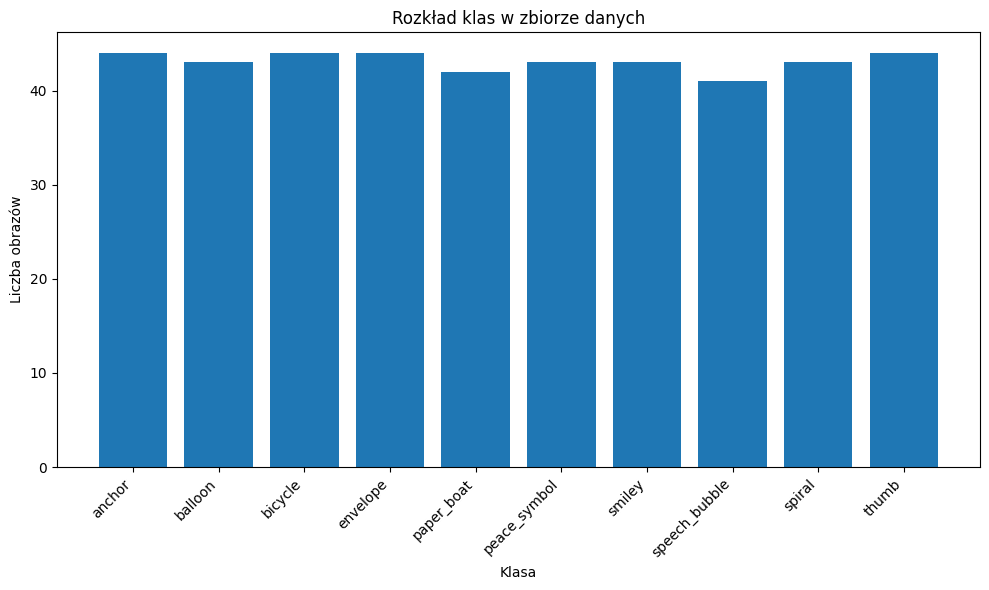


Wyświetlanie przykładowych obrazów...


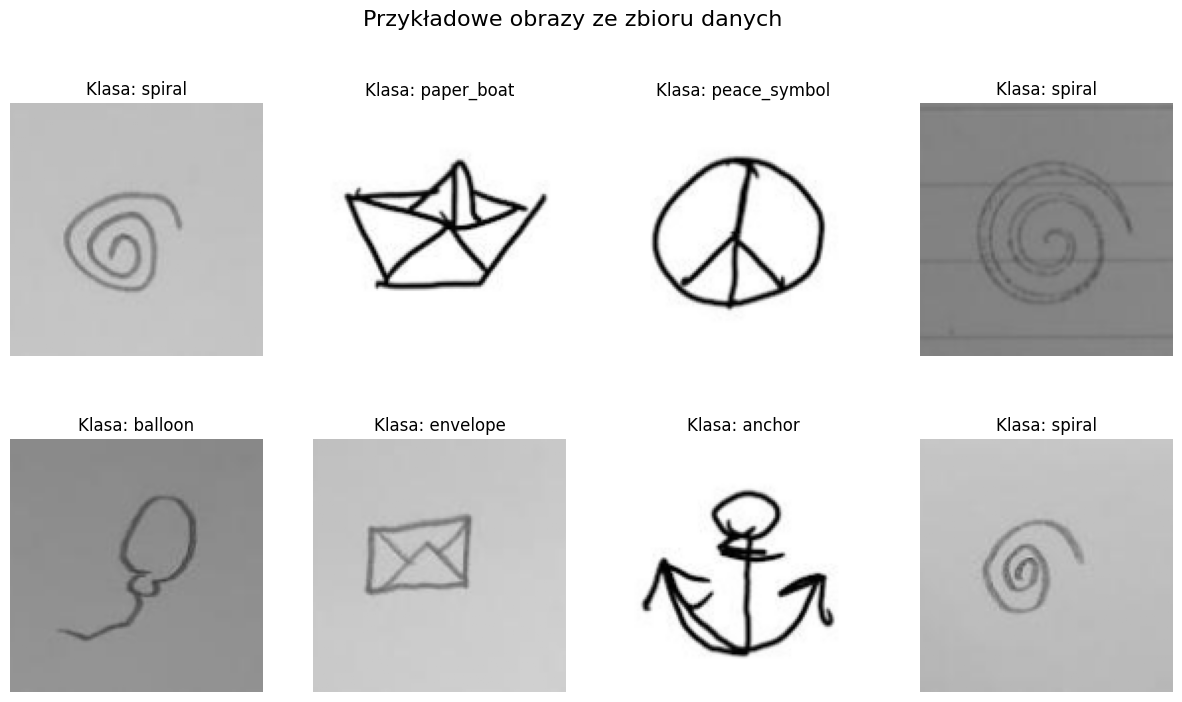


Analiza właściwości obrazów (średnia, odch. standardowe)...
Średnia wartość pikseli (RGB): [0.7509697079658508, 0.7509697079658508, 0.7509697079658508]
Odchylenie standardowe pikseli (RGB): [0.22635377943515778, 0.22635377943515778, 0.22635377943515778]
Wizualna inspekcja przykładowych obrazów jest kluczowa do oceny jakości (ostrość, artefakty, oświetlenie).

--- Koniec analizy ---


In [4]:
def analyze_dataset(dataset_path: str):
    print(f"--- Analiza zbioru danych w: {dataset_path} ---")

    if not os.path.isdir(dataset_path):
        print(f"\nBŁĄD: Folder ze zbiorem danych nie został znaleziony pod adresem '{dataset_path}'")
        print("Proszę zaktualizować zmienną 'dataset_root' w skrypcie.")
        return

    transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor()
    ])

    try:
        dataset = ImageFolder(root=dataset_path, transform=transform)
    except (FileNotFoundError, RuntimeError) as e:
        print(f"\nBŁĄD: Nie można załadować zbioru danych. Sprawdź strukturę folderów.")
        print(f"Szczegóły błędu: {e}")
        return
        
    print(f"\nZnaleziono {len(dataset)} obrazów.")

    num_classes = len(dataset.classes)
    class_names = dataset.classes
    print(f"Liczba klas: {num_classes}")
    print(f"Nazwy klas: {class_names}")

    print("\nAnaliza rozkładu klas:")
    class_counts = Counter(dataset.targets)
    most_common = class_counts.most_common()
    print(f"Najliczniejsza klasa: '{class_names[most_common[0][0]]}' ({most_common[0][1]} obrazów)")
    print(f"Najmniej liczna klasa: '{class_names[most_common[-1][0]]}' ({most_common[-1][1]} obrazów)")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, [class_counts[i] for i in range(num_classes)])
    plt.title('Rozkład klas w zbiorze danych')
    plt.xlabel('Klasa')
    plt.ylabel('Liczba obrazów')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nWyświetlanie przykładowych obrazów...")
    sample_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    images, labels = next(iter(sample_loader))

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('Przykładowe obrazy ze zbioru danych', fontsize=16)
    for i, ax in enumerate(axes.flat):
        # Konwersja tensora do obrazu numpy
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"Klasa: {class_names[labels[i]]}")
        ax.axis('off')
    plt.show()

    print("\nAnaliza właściwości obrazów (średnia, odch. standardowe)...")
    loader_stats = DataLoader(dataset, batch_size=64)

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader_stats:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    print(f"Średnia wartość pikseli (RGB): {mean.tolist()}")
    print(f"Odchylenie standardowe pikseli (RGB): {std.tolist()}")
    print("Wizualna inspekcja przykładowych obrazów jest kluczowa do oceny jakości (ostrość, artefakty, oświetlenie).")
    print("\n--- Koniec analizy ---")

analyze_dataset(DATASET_ROOT)

Zbiór danych jest zbalansowany pod względem liczby próbek w każdej klasie.
### Potencjalne problemy

- Niektóre obrazy są mało wyraźne — dotyczy to głównie klas `draw` i `stamp`.
- Niektóre obiekty typu `stamp` są umieszczone na zakratkowanym tle, co może utrudniać klasyfikację.

## 3. Przygotowanie danych (Preprocessing)

Zaimplementowany Preprocesing danych obejmuje:
- **Podział na zbiory**: treningowy, walidacyjny i testowy.
- **Augmentację danych**: Sztuczne zwiększenie zbioru treningowego poprzez losowe transformacje (obroty i crop), co pomaga modelowi w generalizacji.
- **Normalizację**: Przeskalowanie wartości pikseli do standardowego zakresu, co stabilizuje i przyspiesza proces uczenia.
- **Redukcję wymiarów**: Zmniejszenie rozmiaru obrazów do 128x128 pikseli, co przyspiesza trening i zmniejsza zużycie pamięci.
- **gray-scale**: Konwersję obrazów na czarno-białe w celu uproszczenia danych wejściowych, w których kolory nie są istotne, ponieważ rozpoznajemy kształty na białym tle.
- **Utworzenie Dataloderów**: Obiektów, które zarządzają dostarczaniem danych do modelu w trakcie treningu.


In [18]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import os

def get_mean_std(loader: DataLoader):
    mean = 0.
    std = 0.
    total_images_count = 0
    print("Obliczanie średniej i odchylenia standardowego na zbiorze treningowym...")
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    print("Obliczanie zakończone.")
    return mean, std

def create_dataloaders(dataset_path: str, batch_size: int = 32, train_split: float = 0.7, val_split: float = 0.15):
    if not os.path.isdir(dataset_path):
        print(f"BŁĄD: Folder ze zbiorem danych nie został znaleziony pod adresem '{dataset_path}'")
        return None, None, None, None

    initial_transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    dataset = ImageFolder(root=dataset_path, transform=initial_transform)
    class_names = dataset.classes
    print(f"Znaleziono {len(dataset)} obrazów w {len(class_names)} klasach.")

    test_split = 1 - train_split - val_split
    if test_split < 0:
        raise ValueError("Suma podziałów (train_split, val_split) nie może przekraczać 1.0")

    train_size = int(train_split * len(dataset))
    val_size = int(val_split * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    print(f"Podział danych: Treningowe: {len(train_dataset)}, Walidacyjne: {len(val_dataset)}, Testowe: {len(test_dataset)}")


    temp_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    mean, std = get_mean_std(temp_train_loader)
    print(f"Obliczona średnia: {mean.tolist()}")
    print(f"Obliczone odchylenie standardowe: {std.tolist()}")

    train_transforms = transforms.Compose([
        transforms.RandomCrop(128, padding=4),
        transforms.RandomRotation(10),
        transforms.Normalize(mean=mean, std=std)
    ])

    val_test_transforms = transforms.Compose([
        transforms.Normalize(mean=mean, std=std)
    ])


    class TransformedDataset(Subset):
        def __init__(self, subset, transform=None):
            super().__init__(subset.dataset, subset.indices)
            self.transform = transform

        def __getitem__(self, idx):
            x, y = super().__getitem__(idx)
            if self.transform:
                x = self.transform(x)
            return x, y

    train_dataset = TransformedDataset(train_dataset, train_transforms)
    val_dataset = TransformedDataset(val_dataset, val_test_transforms)
    test_dataset = TransformedDataset(test_dataset, val_test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    print("\nDataLoadery zostały pomyślnie utworzone.")
    return train_loader, val_loader, test_loader, class_names

if __name__ == '__main__':
    DATASET_ROOT = './Data'
    
    train_loader, val_loader, test_loader, class_names = create_dataloaders(DATASET_ROOT)

    if train_loader:
        print("\nSprawdzanie paczki danych z train_loader...")
        images, labels = next(iter(train_loader))
        print(f"Rozmiar paczki obrazów: {images.shape}") 
        print(f"Rozmiar paczki etykiet: {labels.shape}")   
        print(f"Przykładowa etykieta: {labels[0].item()} ({class_names[labels[0]]})")
        print(f"Min/Max wartości pikseli po normalizacji: {images.min():.2f}/{images.max():.2f}")


Znaleziono 431 obrazów w 10 klasach.
Podział danych: Treningowe: 301, Walidacyjne: 64, Testowe: 66
Obliczanie średniej i odchylenia standardowego na zbiorze treningowym...
Obliczanie zakończone.
Obliczona średnia: [0.7695574164390564]
Obliczone odchylenie standardowe: [0.11917585879564285]

DataLoadery zostały pomyślnie utworzone.

Sprawdzanie paczki danych z train_loader...


/home/pawel/Desktop/Github/Solvro Application Task/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Rozmiar paczki obrazów: torch.Size([32, 1, 128, 128])
Rozmiar paczki etykiet: torch.Size([32])
Przykładowa etykieta: 2 (bicycle)
Min/Max wartości pikseli po normalizacji: 0.00/1.00


## 4. Budowa + trening modelu NN

Zdecydowałem się stworzyć model NN z racji tego, że jestem najbardziej zaznajomiony z tą architekturą spośród dostępnych opcji. Również owy model był stosowany do identyfikacji cyfr w zbiorze MNIST, który również składa się z 10 klas, co przekonało mnie do jego użycia.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from preprocessing import create_dataloaders
import time
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class SimpleNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1 * 128 * 128, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #here imp
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, return_preds=False):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            
            if return_preds:
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    
    if return_preds:
        return epoch_loss, epoch_acc, all_preds, all_labels
    return epoch_loss, epoch_acc


DATASET_ROOT = './Data'
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_EPOCHS = 120
MODEL_SAVE_PATH = './best_nn_model.pth'
train_loader, val_loader, test_loader, class_names = create_dataloaders(DATASET_ROOT, batch_size=BATCH_SIZE)
if not train_loader:
    print(f"Brak danych treningowych w {DATASET_ROOT}. Upewnij się, że funkcja create_dataloaders zwraca poprawne DataLoadery.")
    raise SystemExit(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")
model = SimpleNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
best_val_acc = 0.0

print("\n--- Rozpoczęcie treningu (Sieć Neuronowa) ---")
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoka {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Czas: {epoch_duration:.2f}s")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Zapisano nowy najlepszy model z dokładnością: {best_val_acc:.4f}")

print("\n--- Zakończono trening ---")
print("\n--- Testowanie najlepszego modelu na zbiorze testowym ---")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device, return_preds=True)


Znaleziono 431 obrazów w 10 klasach.
Podział danych: Treningowe: 301, Walidacyjne: 64, Testowe: 66
Obliczanie średniej i odchylenia standardowego na zbiorze treningowym...
Obliczanie zakończone.
Obliczona średnia: [0.7614045739173889]
Obliczone odchylenie standardowe: [0.11563173681497574]

DataLoadery zostały pomyślnie utworzone.
Używane urządzenie: cpu

--- Rozpoczęcie treningu (Sieć Neuronowa) ---
Obliczanie zakończone.
Obliczona średnia: [0.7614045739173889]
Obliczone odchylenie standardowe: [0.11563173681497574]

DataLoadery zostały pomyślnie utworzone.
Używane urządzenie: cpu

--- Rozpoczęcie treningu (Sieć Neuronowa) ---


/home/pawel/Desktop/Github/Solvro Application Task/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoka 1/120 | Train Loss: 2.3298, Train Acc: 0.1030 | Val Loss: 2.3185, Val Acc: 0.0469 | Czas: 0.50s
Zapisano nowy najlepszy model z dokładnością: 0.0469
Epoka 2/120 | Train Loss: 2.3125, Train Acc: 0.0963 | Val Loss: 2.3049, Val Acc: 0.0469 | Czas: 0.46s
Epoka 2/120 | Train Loss: 2.3125, Train Acc: 0.0963 | Val Loss: 2.3049, Val Acc: 0.0469 | Czas: 0.46s
Epoka 3/120 | Train Loss: 2.3128, Train Acc: 0.0731 | Val Loss: 2.3013, Val Acc: 0.1094 | Czas: 0.50s
Zapisano nowy najlepszy model z dokładnością: 0.1094
Epoka 3/120 | Train Loss: 2.3128, Train Acc: 0.0731 | Val Loss: 2.3013, Val Acc: 0.1094 | Czas: 0.50s
Zapisano nowy najlepszy model z dokładnością: 0.1094
Epoka 4/120 | Train Loss: 2.3004, Train Acc: 0.0997 | Val Loss: 2.3019, Val Acc: 0.1250 | Czas: 0.48s
Zapisano nowy najlepszy model z dokładnością: 0.1250
Epoka 4/120 | Train Loss: 2.3004, Train Acc: 0.0997 | Val Loss: 2.3019, Val Acc: 0.1250 | Czas: 0.48s
Zapisano nowy najlepszy model z dokładnością: 0.1250
Epoka 5/120 | Train L

## Ewaluacja modelu


Wyniki na zbiorze testowym -> Strata: 1.9020, Dokładność: 0.4545

--- Raport Klasyfikacji ---
               precision    recall  f1-score   support

       anchor       0.78      0.88      0.82         8
      balloon       0.50      0.80      0.62         5
      bicycle       0.50      0.25      0.33         4
     envelope       0.50      0.43      0.46         7
   paper_boat       1.00      0.38      0.56        13
 peace_symbol       1.00      0.11      0.20         9
       smiley       0.10      0.20      0.13         5
speech_bubble       0.38      0.56      0.45         9
       spiral       0.00      0.00      0.00         3
        thumb       0.30      1.00      0.46         3

     accuracy                           0.45        66
    macro avg       0.51      0.46      0.40        66
 weighted avg       0.62      0.45      0.45        66



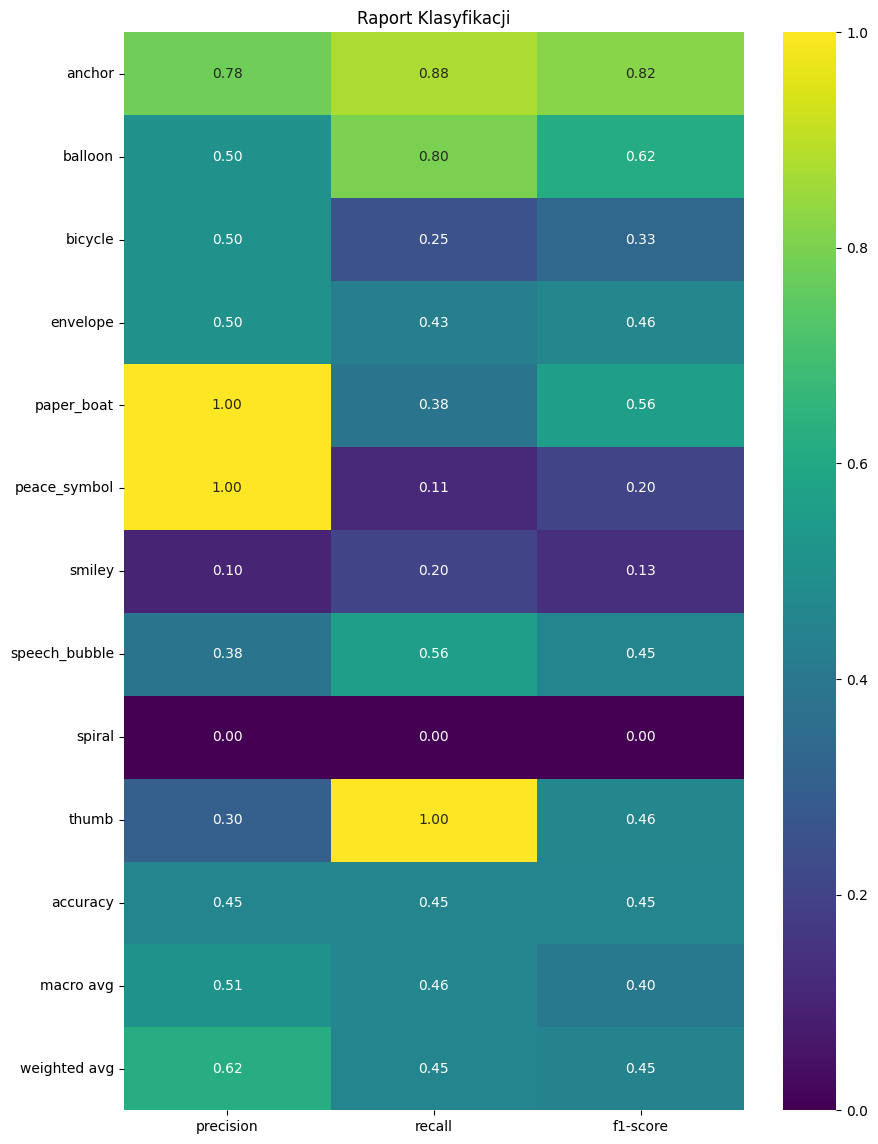


--- Macierz Pomyłek ---


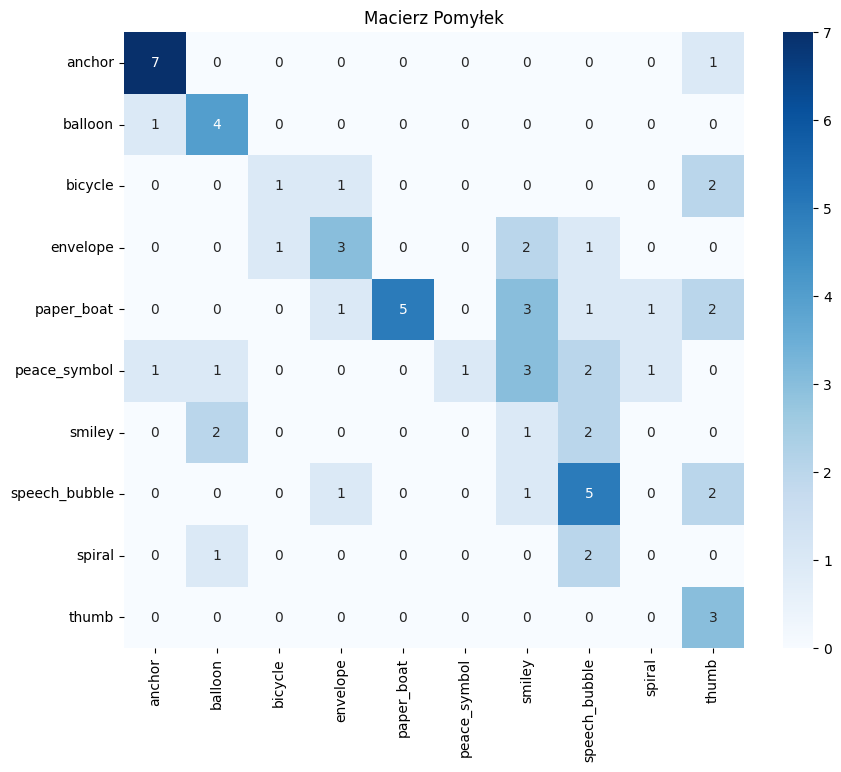

In [3]:
print(f"Wyniki na zbiorze testowym -> Strata: {test_loss:.4f}, Dokładność: {test_acc:.4f}")
print("\n--- Raport Klasyfikacji ---")
report_dict = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True)
print(classification_report(test_labels, test_preds, target_names=class_names))
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T
plt.figure(figsize=(10, len(class_names) + 4))
sns.heatmap(report_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Raport Klasyfikacji')
plt.show()
print("\n--- Macierz Pomyłek ---")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Macierz Pomyłek')
plt.show()

Najlepszy model, jaki udało mi się wytrenować osiągnął maksymalnie około 50-60% dokładności na zbiorze walidacyjnym.

### Uzasadnienie wyboru metryk

Do oceny modelu zastosowałem następujące metryki, które pozwalają na dokładniejszy wgląd niż accuracy, zwłaszcza, że zbiór testowy nie koniecznie musi być zbalansowany

- **Precyzja (Precision)**  
  - **Co mierzy?** Jak duży odsetek rysunków, które model oznaczył jako np. "balon", to faktycznie balony.  
  - Wzór (dla klasy i):  
    $$\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}$$

- **Czułość (Recall)**  
  - **Co mierzy?** Jaki odsetek wszystkich faktycznych "balonów" w zbiorze testowym model był w stanie poprawnie zidentyfikować.  
  - Wzór (dla klasy i):  
    $$\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}$$

- **F1-Score**  
  - **Co mierzy?** Średnia harmoniczna precyzji i czułości. Stanowi pojedynczą metrykę, która równoważy oba te wskaźniki.  
  - Wzór (dla klasy i):  
    $$\text{F1}_i = 2 \cdot \frac{\text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i} = \frac{2 TP_i}{2 TP_i + FP_i + FN_i}$$

- **Macro Average F1-Score (`macro-avg`)**  
  - Oblicza F1-Score dla każdej klasy osobno, a następnie wyciąga z nich prostą średnią. Każda klasa ma taką samą wagę.  
  - Wzór:  
    $$\text{F1}_{\text{macro}} = \frac{1}{K}\sum_{i=1}^{K} \text{F1}_i$$
    gdzie K to liczba klas.

- **Weighted Average F1-Score (`weighted-avg`)**  
  - Podobna do `macro-avg`, ale przy uśrednianiu bierze pod uwagę liczebność każdej klasy (`support`). Klasy z większą liczbą próbek mają większy wpływ na końcowy wynik.  
  - Wzór:  
    $$\text{F1}_{\text{weighted}} = \frac{1}{N}\sum_{i=1}^{K} s_i \cdot \text{F1}_i$$
    gdzie \(s_i\) to support (liczba próbek klasy i), a \(N=\sum_{i=1}^{K} s_i\).


## 4. Budowa i trening modelu CNN

Z racji tego, że nie jestem usatysfakcjonowany wynikami uzyskanymi przez model NN, zdecydowałem się na implementację nowego modelu CNN, który jest moim pierszym zetknięciem z tą architekturą(musiałem się w między czasie doszkolić z dziłania CNN).

CNN powinien lepiej radzić sobie z rozpoznawaniem obrazów dzięki swojej zdolności do wykrywania cech przestrzennych w odróżnieniu od standardowego modelu NN, zwłaszcza, że obrazy w naszym zbiorze danych zawierają różnorodne kształty i wzory, które mogą być lepiej uchwycone przez warstwy konwolucyjne. Także zakratkowane tło w niektórych obrazach może być lepiej zignorowane przez CNN, które potrafią skupić się na istotnych cechach obrazu.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Blok 1: Wejście (1, 128, 128) -> Wyjście (16, 64, 64)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Blok 2: Wejście (16, 64, 64) -> Wyjście (32, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Blok 3: Wejście (32, 32, 32) -> Wyjście (32, 16, 16)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Rozmiar wejściowy: 32 kanały * 16 * 16 (po ostatnim poolingu)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 16 * 16, 80)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(80, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Trening CNN

In [6]:
DATASET_ROOT = './Data'
BATCH_SIZE = 35
LEARNING_RATE = 0.001
NUM_EPOCHS = 35
MODEL_SAVE_PATH = './best_model.pth'

train_loader, val_loader, test_loader, class_names = create_dataloaders(DATASET_ROOT, batch_size=BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

model_cnn = SimpleCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=LEARNING_RATE)

best_val_acc = 0.0

print("\n--- Rozpoczęcie treningu CNN ---")
for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_epoch(model_cnn, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_cnn, val_loader, criterion, device)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoka {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"Czas: {epoch_duration:.2f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_cnn.state_dict(), MODEL_SAVE_PATH)
        print(f"Zapisano nowy najlepszy model z dokładnością: {best_val_acc:.4f}")

print("\n--- Zakończono trening ---")

Znaleziono 431 obrazów w 10 klasach.
Podział danych: Treningowe: 301, Walidacyjne: 64, Testowe: 66
Obliczanie średniej i odchylenia standardowego na zbiorze treningowym...
Obliczanie zakończone.
Obliczona średnia: [0.7574596405029297]
Obliczone odchylenie standardowe: [0.11309908330440521]

DataLoadery zostały pomyślnie utworzone.
Używane urządzenie: cpu

--- Rozpoczęcie treningu CNN ---
Obliczanie zakończone.
Obliczona średnia: [0.7574596405029297]
Obliczone odchylenie standardowe: [0.11309908330440521]

DataLoadery zostały pomyślnie utworzone.
Używane urządzenie: cpu

--- Rozpoczęcie treningu CNN ---


/home/pawel/Desktop/Github/Solvro Application Task/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoka 1/35 | Train Loss: 2.3117, Train Acc: 0.0897 | Val Loss: 2.3099, Val Acc: 0.0625 | Czas: 2.08s
Zapisano nowy najlepszy model z dokładnością: 0.0625
Epoka 2/35 | Train Loss: 2.3004, Train Acc: 0.1196 | Val Loss: 2.3252, Val Acc: 0.0625 | Czas: 1.78s
Epoka 2/35 | Train Loss: 2.3004, Train Acc: 0.1196 | Val Loss: 2.3252, Val Acc: 0.0625 | Czas: 1.78s
Epoka 3/35 | Train Loss: 2.2997, Train Acc: 0.1130 | Val Loss: 2.3289, Val Acc: 0.0625 | Czas: 1.77s
Epoka 3/35 | Train Loss: 2.2997, Train Acc: 0.1130 | Val Loss: 2.3289, Val Acc: 0.0625 | Czas: 1.77s
Epoka 4/35 | Train Loss: 2.2893, Train Acc: 0.1329 | Val Loss: 2.3243, Val Acc: 0.0781 | Czas: 1.88s
Zapisano nowy najlepszy model z dokładnością: 0.0781
Epoka 4/35 | Train Loss: 2.2893, Train Acc: 0.1329 | Val Loss: 2.3243, Val Acc: 0.0781 | Czas: 1.88s
Zapisano nowy najlepszy model z dokładnością: 0.0781
Epoka 5/35 | Train Loss: 2.2461, Train Acc: 0.1827 | Val Loss: 2.2818, Val Acc: 0.1875 | Czas: 1.75s
Zapisano nowy najlepszy model z d

## 5. Ewaluacja modelu CNN
Metryki użyte do oceny modelu CNN są takie same jak w przypadku modelu NN, z tych samych powodów.


--- Testowanie najlepszego modelu na zbiorze testowym ---


/home/pawel/Desktop/Github/Solvro Application Task/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Wyniki na zbiorze testowym -> Strata: 0.3794, Dokładność: 0.8939

--- Raport Klasyfikacji ---
               precision    recall  f1-score   support

       anchor       0.75      0.75      0.75         4
      balloon       1.00      1.00      1.00         9
      bicycle       1.00      1.00      1.00         7
     envelope       0.88      1.00      0.93         7
   paper_boat       0.78      1.00      0.88         7
 peace_symbol       0.80      0.67      0.73         6
       smiley       0.88      0.88      0.88         8
speech_bubble       0.86      0.86      0.86         7
       spiral       1.00      0.75      0.86         4
        thumb       1.00      0.86      0.92         7

     accuracy                           0.89        66
    macro avg       0.89      0.88      0.88        66
 weighted avg       0.90      0.89      0.89        66



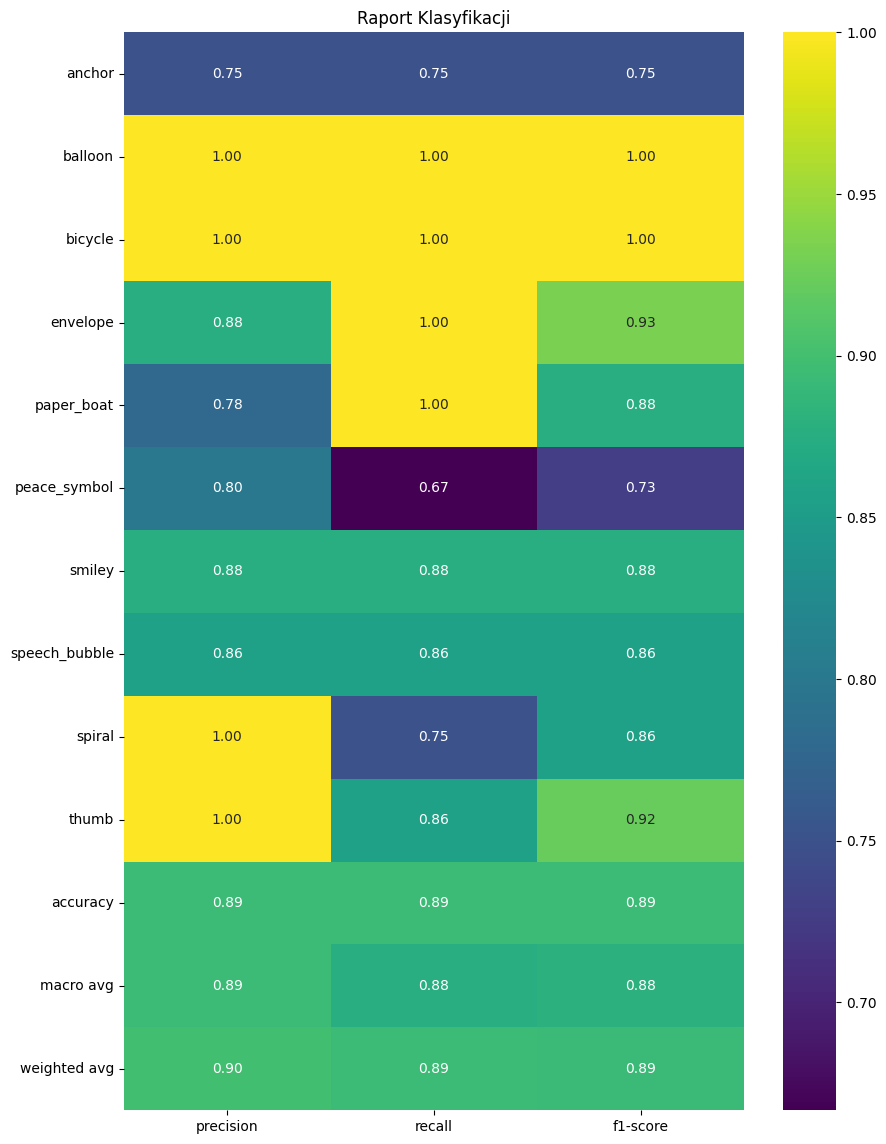


--- Macierz Pomyłek ---


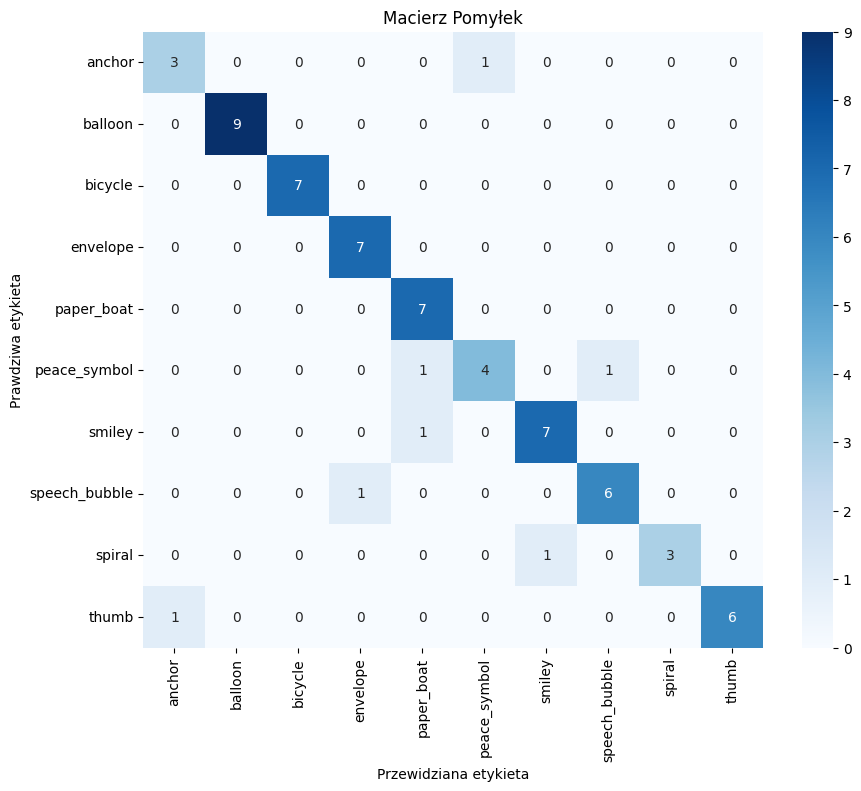

In [11]:
print("\n--- Testowanie najlepszego modelu na zbiorze testowym ---")
model_cnn.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_acc, test_preds, test_labels = evaluate(model_cnn, test_loader, criterion, device, return_preds=True)
print(f"Wyniki na zbiorze testowym -> Strata: {test_loss:.4f}, Dokładność: {test_acc:.4f}")

print("\n--- Raport Klasyfikacji ---")
report_dict = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True)
print(classification_report(test_labels, test_preds, target_names=class_names))
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T
plt.figure(figsize=(10, len(class_names) + 4))
sns.heatmap(report_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Raport Klasyfikacji')
plt.show()

print("\n--- Macierz Pomyłek ---")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Przewidziana etykieta')
plt.ylabel('Prawdziwa etykieta')
plt.title('Macierz Pomyłek')
plt.show()

## 7. Porównanie z modelem alternatywnym (Random Forest)

Znaleziono 431 obrazów w 10 klasach.
Podział danych: Treningowe: 344, Walidacyjne: 0, Testowe: 87
Obliczanie średniej i odchylenia standardowego na zbiorze treningowym...
Obliczanie zakończone.
Obliczona średnia: [0.7518401145935059]
Obliczone odchylenie standardowe: [0.11272755265235901]

DataLoadery zostały pomyślnie utworzone.
Przetwarzanie danych z TransformedDataset...
Obliczanie zakończone.
Obliczona średnia: [0.7518401145935059]
Obliczone odchylenie standardowe: [0.11272755265235901]

DataLoadery zostały pomyślnie utworzone.
Przetwarzanie danych z TransformedDataset...


/home/pawel/Desktop/Github/Solvro Application Task/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Przetwarzanie zakończone.
Przetwarzanie danych z TransformedDataset...
Przetwarzanie zakończone.

Rozmiar danych treningowych: (344, 16384)
Rozmiar danych testowych: (87, 16384)

--- Rozpoczęcie trenowania Random Forest ---
Przetwarzanie zakończone.

Rozmiar danych treningowych: (344, 16384)
Rozmiar danych testowych: (87, 16384)

--- Rozpoczęcie trenowania Random Forest ---
--- Zakończono trening w 0.62s ---
Dokładność: 0.4913

--- Testowanie modelu na zbiorze testowym ---
Czas predykcji: 0.03s
Dokładność na zbiorze testowym: 0.5402

--- Raport Klasyfikacji ---
               precision    recall  f1-score   support

       anchor       0.70      0.70      0.70        10
      balloon       0.40      1.00      0.57         6
      bicycle       0.56      0.71      0.62         7
     envelope       1.00      0.40      0.57        10
   paper_boat       0.50      0.83      0.62         6
 peace_symbol       1.00      0.56      0.71         9
       smiley       0.33      0.44      0.38  

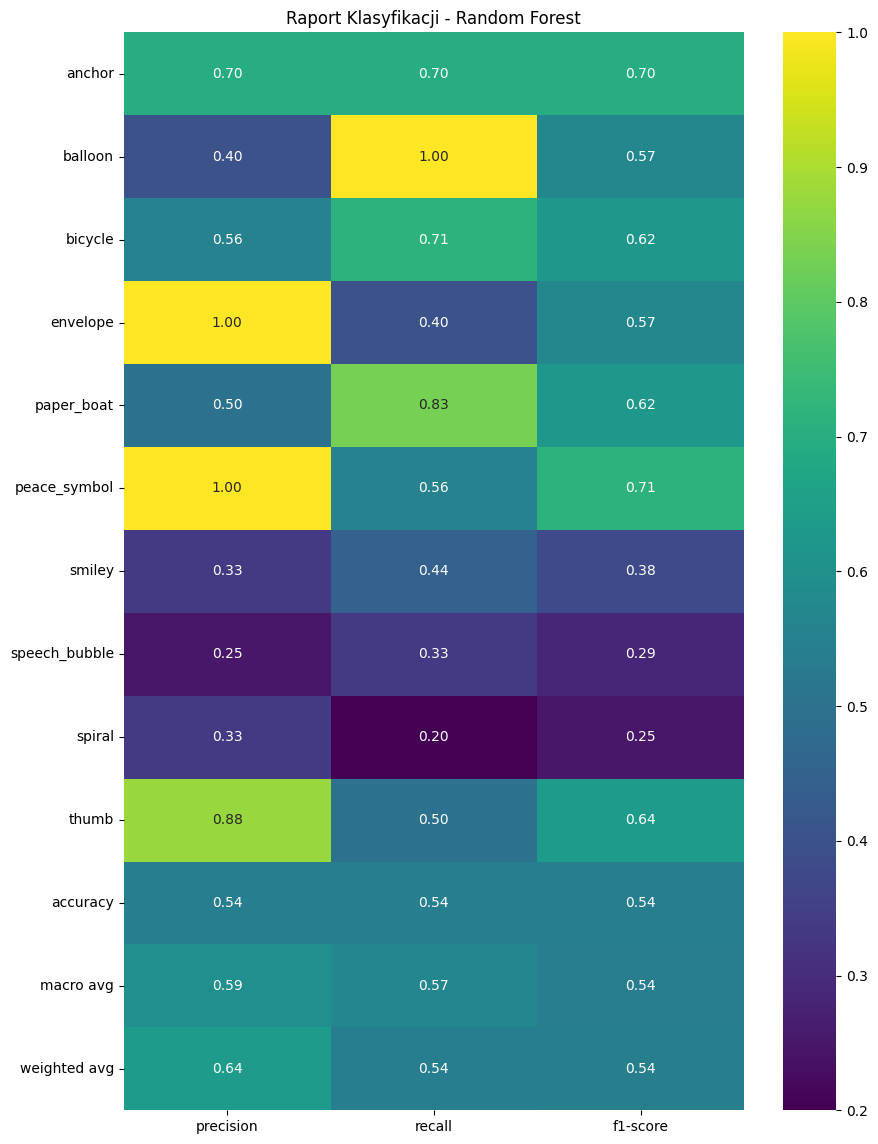


--- Macierz Pomyłek ---


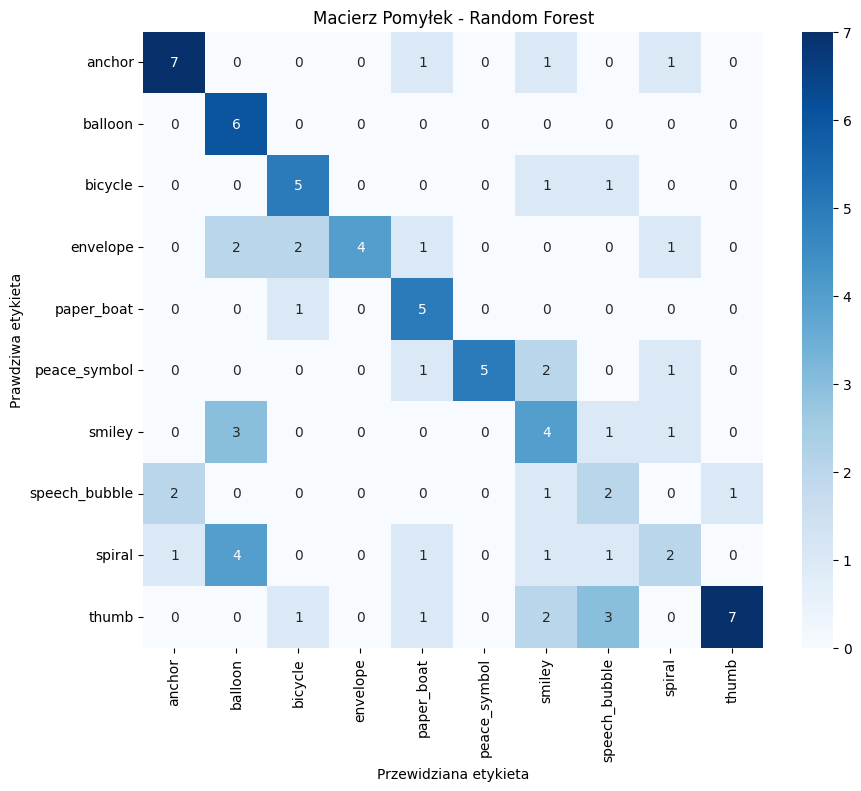

In [ ]:
DATASET_ROOT_RF = './Data'
BATCH_SIZE_RF = 64


train_loader_rf, _, test_loader_rf, class_names_rf = create_dataloaders(
    DATASET_ROOT_RF, 
    batch_size=BATCH_SIZE_RF,
    train_split=0.8, 
    val_split=0.0
)

def get_data_from_loader(loader):

    features = []
    labels = []
    
    print(f"Przetwarzanie danych z {type(loader.dataset).__name__}...")
    for images, lbls in loader:
        # Spłaszczenie obrazów z (batch, channels, height, width) do (batch, features)
        images = images.view(images.shape[0], -1)
        features.append(images.numpy())
        labels.append(lbls.numpy())
        
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    print("Przetwarzanie zakończone.")
    return features, labels

# Konwersja danych z DataLoaderów do formatu NumPy dla Scikit-learn
X_train_rf, y_train_rf = get_data_from_loader(train_loader_rf)
X_test_rf, y_test_rf = get_data_from_loader(test_loader_rf)

print(f"\nRozmiar danych treningowych: {X_train_rf.shape}")
print(f"Rozmiar danych testowych: {X_test_rf.shape}")

print("\n--- Rozpoczęcie trenowania Random Forest ---")
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
rf_classifier.fit(X_train_rf, y_train_rf)

training_duration = time.time() - start_time
print(f"--- Zakończono trening w {training_duration:.2f}s ---")
print(f"Dokładność: {rf_classifier.oob_score_:.4f}")

print("\n--- Testowanie modelu na zbiorze testowym ---")
start_time = time.time()
y_pred_rf = rf_classifier.predict(X_test_rf)
prediction_duration = time.time() - start_time

test_acc_rf = np.mean(y_pred_rf == y_test_rf)
print(f"Czas predykcji: {prediction_duration:.2f}s")
print(f"Dokładność na zbiorze testowym: {test_acc_rf:.4f}")

print("\n--- Raport Klasyfikacji ---")
report_dict_rf = classification_report(y_test_rf, y_pred_rf, target_names=class_names_rf, output_dict=True)
print(classification_report(y_test_rf, y_pred_rf, target_names=class_names_rf))

report_df_rf = pd.DataFrame(report_dict_rf).iloc[:-1, :].T
plt.figure(figsize=(10, len(class_names_rf) + 4))
sns.heatmap(report_df_rf, annot=True, cmap='viridis', fmt='.2f')
plt.title('Raport Klasyfikacji - Random Forest')
plt.show()

print("\n--- Macierz Pomyłek ---")
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=class_names_rf, yticklabels=class_names_rf, cmap='Blues')
plt.title('Macierz Pomyłek - Random Forest')
plt.show()

## 8. Podsumowanie
Z zaimplementowanych modeli najlepsze wyniki osiągnął model CNN. 
Podczas implementacji napotkałem się z rónymi błędami, przeważnie wynikającymi z nieznajomości bibliotek lub nieodpowiedniego użycia funkcji, jak np. zapomniałem dodać optimizer.zero_grad() przed loss.backward() w treningu modelu NN, co skutkowało niepoprawnym aktualizowaniem wag modelu.

### Augumentacja danych
Zauważyłem, również, że augmentacja danych pomogła zapobiec overfittingowi, podczas treningu modeli, modele bez augmentacji osiągały gorszy stosunek pomiędzy dokładnością na zbiorze treningowym i walidacyjnym.


### Miejsca do poprawy
- dalsza optymalizacja architektury modeli i hiperparametrów,
- eksperymenty z różnymi technikami augmentacji danych,
- wprowadzenie wizualizacji procesu treningu (np. wykresy strat i dokładności w czasie)


